<a href="https://colab.research.google.com/github/ctarrington/data-science-hw/blob/master/dbda/ch09-heirarchical-models/mint_discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import theano.tensor as tt
from runpy import run_path

az.style.use('arviz-darkgrid')
%matplotlib inline

     |████████████████████████████████| 1.4MB 7.9MB/s 
     |████████████████████████████████| 4.3MB 29.4MB/s 
     |████████████████████████████████| 296kB 37.6MB/s 
     |████████████████████████████████| 911kB 7.7MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [2]:
!rm -rf data-science-hw
!git clone https://github.com/ctarrington/data-science-hw.git

base_path = './data-science-hw/dbda/ch08-basic-models/'
Coin = run_path(base_path+'/mint.py').get('Coin')
Mint = run_path(base_path+'/mint.py').get('Mint')

Cloning into 'data-science-hw'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (215/215), done.
remote: Total 242 (delta 120), reused 54 (delta 17), pack-reused 0
Receiving objects: 100% (242/242), 17.02 MiB | 13.77 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [3]:
coins_per_mint = 40

mint = Mint(0.2, 0.00005)
coins = mint.make_coins(coins_per_mint)

mint = Mint(0.5, 0.00005)
mint.make_coins(coins_per_mint, coins)

mint = Mint(0.8, 0.00005)
mint.make_coins(coins_per_mint, coins)

clusters = 3


In [4]:
flips = []
for ctr in range(100):
  for coin in coins:
    coin.flip(flips)

In [5]:
df = pd.DataFrame(flips, columns=['mint_id', 'coin_id', 'flip'])
df.drop(columns=['mint_id'], inplace=True)

min_coin_id = np.min(df['coin_id'])
df['coin_id'] = df['coin_id'] - min_coin_id

df = df.groupby('coin_id').agg(['count', 'sum']).reset_index()
df.columns=['coin_id', 'attempts', 'heads']
df['p'] = df['heads']/df['attempts']

df = df.sample(frac=1).reset_index(drop=True)


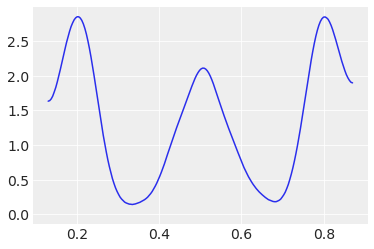

In [6]:
az.plot_kde(df['p'])

In [8]:
with pm.Model() as model:
    mint_idx = pm.Dirichlet('mint_idx', a=np.ones(clusters))
    mint_means = pm.Normal('mint_means',
                           mu=np.linspace(df['p'].min(), df['p'].max(), clusters),
                           sd=1,
                           shape=clusters,
                           transform=pm.distributions.transforms.ordered) # prevent label switching

    sd = pm.HalfNormal('sd', sd=0.1)
    y = pm.NormalMixture('y', w=mint_idx, mu=mint_means, sd=sd, observed=df['p'])

    trace = pm.sample(1000, tune=3000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, mint_means, mint_idx]
Sampling chain 1, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 347.27it/s]


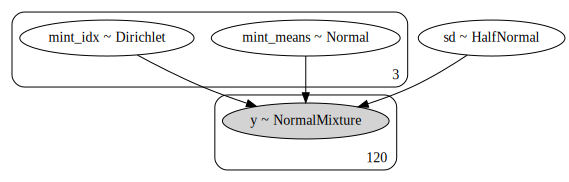

In [9]:
pm.model_to_graphviz(model)

In [10]:
print(az.summary(trace))


                mean     sd  hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
mint_idx[0]    0.339  0.044   0.264    0.426  ...  2648.0    2669.0    1418.0    1.0
mint_idx[1]    0.330  0.043   0.254    0.413  ...  2679.0    2684.0    1417.0    1.0
mint_idx[2]    0.331  0.044   0.253    0.412  ...  2724.0    2770.0    1286.0    1.0
mint_means[0]  0.205  0.008   0.191    0.219  ...  1755.0    1773.0    1531.0    1.0
mint_means[1]  0.508  0.008   0.494    0.524  ...  2112.0    2112.0    1710.0    1.0
mint_means[2]  0.799  0.008   0.786    0.814  ...  2279.0    2283.0    1647.0    1.0
sd             0.046  0.003   0.040    0.051  ...  2330.0    2366.0    1484.0    1.0

[7 rows x 11 columns]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc889b49dd8>],
      dtype=object)

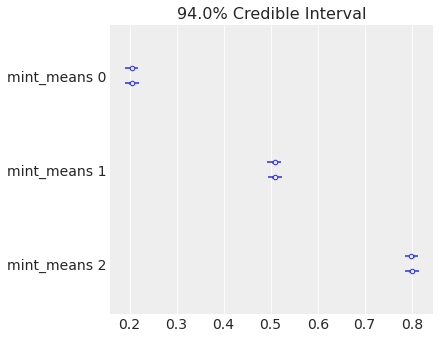

In [11]:
az.plot_forest(trace, var_names='mint_means')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc88759b7b8>,
      dtype=object)

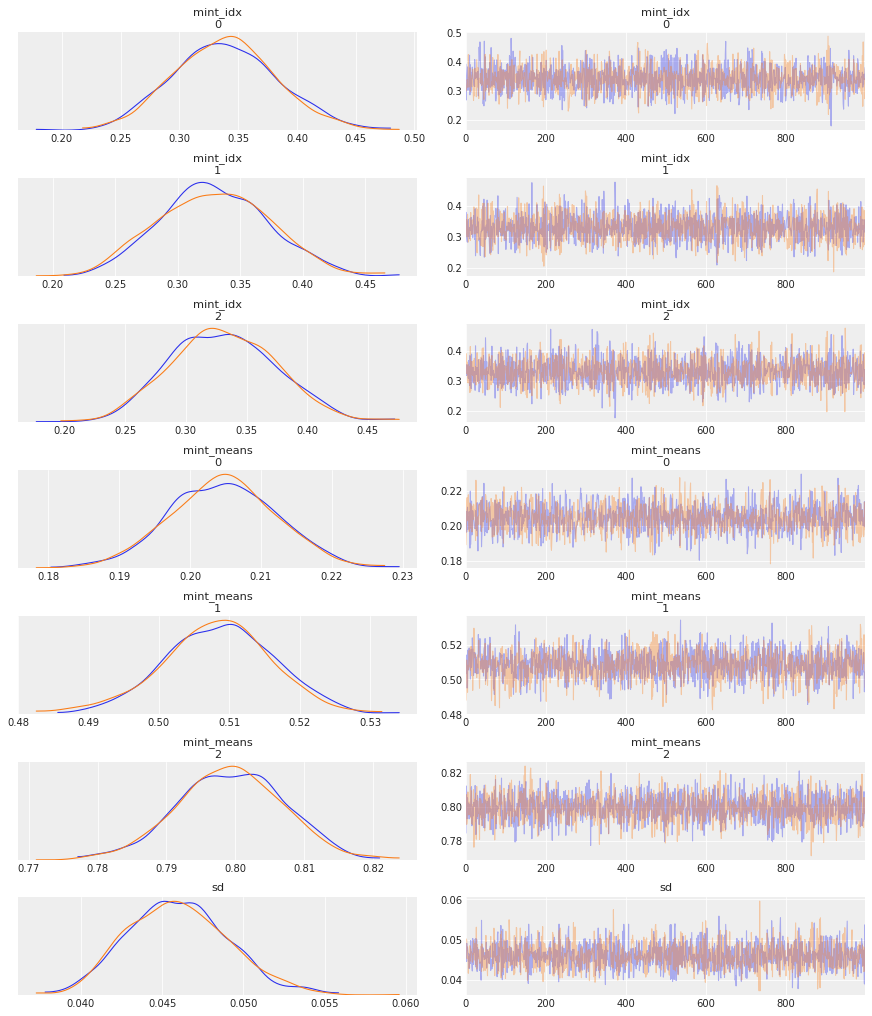

In [12]:
az.plot_trace(trace)